In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import StripePattern, ScrollZoomToggler, DualMap, FloatImage
import branca.colormap as cm
import random
import json
import warnings
import shapely
import os
import tqdm
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [7]:
state_dict = dict(
    az_2020={"districts": 9, "crs": "EPSG:2223"},
    ca_2020={"districts": 52, "crs": "EPSG:2225"},
    ct_2020={"districts": 5, "crs": "EPSG:2234"},
    fl_2020={"districts": 28, "crs": "EPSG:2225"},
    ga_2020={"districts": 14, "crs": "EPSG:2240"},
    ma_2020={"districts": 9, "crs": "EPSG:2249"},
    md_2020={"districts": 8, "crs": "EPSG:2248"},
    mi_2020={"districts": 13, "crs": "EPSG:2252"},
    mn_2020={"districts": 8, "crs": "EPSG:2811"},
    nc_2020={"districts": 14, "crs": "EPSG:2264"},
    nh_2020={"districts": 2, "crs": "EPSG:3437"},
    nj_2020={"districts": 12, "crs": "EPSG:2824"},
    nv_2020={"districts": 4, "crs": "EPSG:2821"},
    oh_2020={"districts": 15, "crs": "EPSG:2834"},
    or_2020={"districts": 6, "crs": "EPSG:2269"},
    pa_2020={"districts": 17, "crs": "EPSG:2271"},
    sc_2020={"districts": 7, "crs": "EPSG:2273"},
    tx_2020={"districts": 38, "crs": "EPSG:2277"},
    va_2020={"districts": 11, "crs": "EPSG:2283"},
    wi_2020={"districts": 8, "crs": "EPSG:2288"},
)

In [8]:
actual_results = pd.read_excel("../redistricting/2022_congressional_voting_results.xlsx")
actual_results["district"] = actual_results["district"].astype(str)
states = sorted(actual_results["state"].unique())
run = "moving_knife_c" # "original_scorer_2020"

In [9]:
def reock_score(geom):
    geom_area = geom.geometry.area
    min_circle = geom.geometry.minimum_bounding_circle()
    min_circle_area = min_circle.area
    reock_score = geom_area / min_circle_area
    return reock_score

def dissolve_df(df, buffer_width=1e-4):
    dissolved = df.dissolve(by=f'DISTRICT_', aggfunc="sum").reset_index()
    dissolved = dissolved[['geometry', 'POP20', 'USH20_D', 'USH20_R']]
    dissolved['geometry'] = dissolved.buffer(buffer_width)
    dissolved['district'] = dissolved.index
    dissolved['district'] = dissolved['district'] + 1
    dissolved["Dem_PCT"] = round(
        dissolved['USH20_D']/(dissolved['USH20_D']+dissolved['USH20_R']), 4)*100
    return dissolved


In [10]:
def get_vote_hist(actual, algo):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,3))
    fig.suptitle('Democratic Voting Shares (%) by District')
    ax[0].set_title('Actual Results (2022)')
    ax[1].set_title('Simulated Results (2020)')
    bins = [i for i in range(0,101,5)]
    sns.histplot(ax=ax[0], x=actual,bins=bins, color="lightgreen")
    sns.histplot(ax=ax[1], x=algo,bins=bins, color="orange")
    fig.tight_layout()

    
def get_reock_hist(actual, algo, overall):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,3))
    fig.suptitle(f'Reock Score by District (State Overall = {overall})')
    ax[0].set_title('Actual Results (2022)')
    ax[1].set_title('Simulated Results (2020)')
    actual_mn = round(np.mean(actual),2)
    actual_md = round(np.median(actual),2)
    algo_mn = round(np.mean(algo),2)
    algo_md = round(np.median(algo),2)
    ax[0].set_xlabel(f'Mean = {actual_mn} | Median = {actual_md}')
    ax[1].set_xlabel(f'Mean = {algo_mn} | Median = {algo_md}')
    bins = [i/100. for i in range(0,101,5)]
    sns.histplot(ax=ax[0], x=actual,bins=bins, color="lightgreen")
    sns.histplot(ax=ax[1], x=algo,bins=bins, color="orange")
    fig.tight_layout()

In [11]:
def get_voting_stats(state):
    print(state)
    state_results = actual_results.loc[actual_results["state"] == state].copy()
    state_results = state_results.reset_index(drop=True)
    n_districts = len(state_results)

    algo_districts = gpd.read_file(f"../output/{state.lower()}_2020/{state.lower()}_2020_{run}.shp")

    algo_df = algo_districts.groupby("DISTRICT_")[['POP20', 'USH20_D', 'USH20_R']].sum().reset_index()
    algo_df['Dem_PCT'] = round(algo_df['USH20_D']/(algo_df['USH20_D']+algo_df['USH20_R'])*100,1)
    
    ## Party Vote
    state_results["Dem_PCT"] = (
        100
        * state_results["democrat"]
        / (state_results["democrat"] + state_results["republican"])
    )
    state_results["Dem_PCT"] = state_results["Dem_PCT"].apply(
        lambda x: round(x, 2)
    )
    actual_pv = state_results[["democrat"]].sum()/state_results[["democrat","republican"]].sum().sum()
    actual_pv = round(actual_pv.to_list()[0]*100,1)

    algo_pv = algo_df[["USH20_D"]].sum()/algo_df[["USH20_D","USH20_R"]].sum().sum()
    algo_pv = round(algo_pv.to_list()[0]*100,1)

    print(f"Party Vote (D, R): ({actual_pv}%, {100-actual_pv}%) | ({algo_pv}%, {100-algo_pv}%)")

    ## Seats Won
    actual_seats = state_results.loc[state_results["democrat"] > state_results["republican"]]
    actual_seats = len(actual_seats)

    algo_seats = algo_df.loc[algo_df["USH20_D"] > algo_df["USH20_R"]]
    algo_seats = len(algo_seats)
    print(f"Seats Won (D, R): ({actual_seats}, {n_districts-actual_seats}) | ({algo_seats}, {n_districts-algo_seats})")

    ## Proportional Seating
    actual_prop_seating = round(actual_pv/100. * n_districts)
    algo_prop_seating = round(algo_pv/100. * n_districts)
    print(f"Proportional Seating (D, R): ({actual_prop_seating}, {n_districts-actual_prop_seating}) | ({algo_prop_seating}, {n_districts-algo_prop_seating})")

    ## Competitiveness
    actual_non_comp = len(state_results.loc[(state_results["dem_share"] < 0.45) | (state_results["dem_share"] > 0.55)])
    actual_comp = len(state_results.loc[
        ((state_results["dem_share"] >= 0.45) & (state_results["dem_share"] < 0.475)) | ((state_results["dem_share"] >= 0.525) & (state_results["dem_share"] <= 0.55))
    ])
    actual_very_comp = len(state_results.loc[
        (state_results["dem_share"] >= 0.475) & (state_results["dem_share"] < 0.525)
    ])
    
    algo_non_comp = len(algo_df.loc[(algo_df["Dem_PCT"] < 45) | (algo_df["Dem_PCT"] > 55)])
    algo_comp = len(algo_df.loc[
        ((algo_df["Dem_PCT"] >= 45) & (algo_df["Dem_PCT"] < 47.5)) | ((algo_df["Dem_PCT"] >= 52.5) & (algo_df["Dem_PCT"] <= 55))
    ])
    algo_very_comp = len(algo_df.loc[
        (algo_df["Dem_PCT"] >= 47.5) & (algo_df["Dem_PCT"] < 52.5)
    ])

    print(f"Competitiveness (NC, C, C*): ({actual_non_comp}, {actual_comp}, {actual_very_comp}) | ({algo_non_comp}, {algo_comp}, {algo_very_comp})")

    ## Uncontested Seats
    uncontested_rep_seats = state_results.loc[(state_results['dem_share'] == 0)].shape[0]
    uncontested_dem_seats = state_results.loc[(state_results['dem_share'] == 1)].shape[0]
    print(f"Uncontested Seats (D, R): ({uncontested_dem_seats}, {uncontested_rep_seats})")
    # print(state_results['democrat'],algo_df['Dem_PCT'])
    get_vote_hist(state_results['Dem_PCT'].tolist(), algo_df['Dem_PCT'].tolist())

def get_reock_stats(state):
    actual_districts = gpd.read_file( f"../data/{state.lower()}/district-shapes/POLYGON.shp")
    actual_districts["geometry"] = (actual_districts["geometry"].apply(shapely.validation.make_valid).buffer(1e-9))
    actual_districts = actual_districts.to_crs("EPSG:4326")

    

    algo_districts = gpd.read_file(f"../output/{state.lower()}_2020/{state.lower()}_2020_{run}.shp")
    algo_districts = algo_districts.to_crs("EPSG:4326")
    algo_districts["geometry"] = (algo_districts["geometry"].apply(shapely.validation.make_valid).buffer(1e-9))
    algo_districts = algo_districts.dissolve(by=f'DISTRICT_', aggfunc="sum").reset_index()
    algo_districts['geometry'] = algo_districts.buffer(1e-4)

    # Clipped Scores
    actual_districts_c = gpd.clip(actual_districts,algo_districts)
    actual_reock_c = reock_score(actual_districts_c)
    actual_reock_c_mean = np.mean(actual_reock_c)
    actual_reock_c_median = np.median(actual_reock_c)

    algo_districts_c = gpd.clip(algo_districts,actual_districts)
    algo_reock_c = reock_score(algo_districts_c)
    algo_reock_c_mean = np.mean(algo_reock_c)
    algo_reock_c_median = np.median(algo_reock_c)
    actual_reock_overall_c = reock_score(actual_districts_c.dissolve())[0]


    
    results = {
        "State": state,
        "Actual.Reock.Mean": round(actual_reock_c_mean,5),
        "Algo.Reock.Mean": round(algo_reock_c_mean,5),
        "Actual.Reock.Median": round(actual_reock_c_median,5),
        "Algo.Reock.Median": round(algo_reock_c_median,5),
        "Overall.Reock": round(actual_reock_overall_c,5),
    }

    print(results)
    get_reock_hist(actual_reock_c,algo_reock_c, round(actual_reock_overall_c,2))


AZ
Party Vote (D, R): (43.1%, 56.9%) | (49.9%, 50.1%)
Seats Won (D, R): (3, 6) | (5, 4)
Proportional Seating (D, R): (4, 5) | (4, 5)
Competitiveness (NC, C, C*): (6, 1, 2) | (8, 1, 0)
Uncontested Seats (D, R): (0, 2)
{'State': 'AZ', 'Actual.Reock.Mean': 0.39702, 'Algo.Reock.Mean': 0.53993, 'Actual.Reock.Median': 0.41315, 'Algo.Reock.Median': 0.57551, 'Overall.Reock': 0.64864}


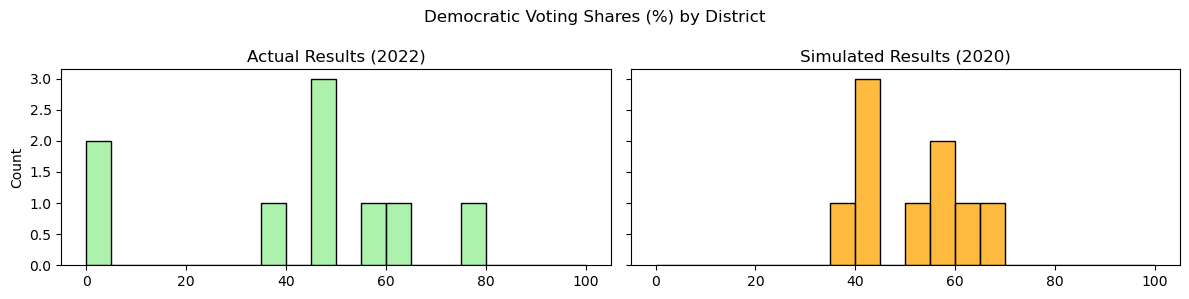

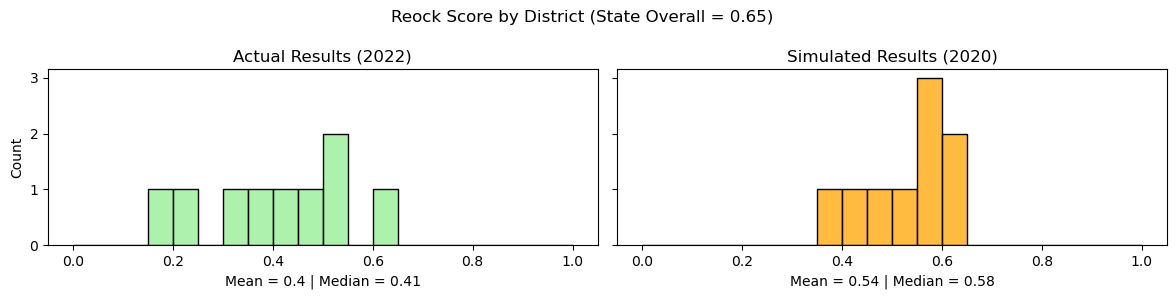

In [12]:
## Arizona
get_voting_stats('AZ')
get_reock_stats('AZ')

CA
Party Vote (D, R): (63.6%, 36.4%) | (66.3%, 33.7%)
Seats Won (D, R): (40, 12) | (44, 8)
Proportional Seating (D, R): (33, 19) | (34, 18)
Competitiveness (NC, C, C*): (41, 6, 5) | (41, 7, 4)
Uncontested Seats (D, R): (7, 0)
{'State': 'CA', 'Actual.Reock.Mean': 0.33204, 'Algo.Reock.Mean': 0.27603, 'Actual.Reock.Median': 0.34895, 'Algo.Reock.Median': 0.25815, 'Overall.Reock': 0.29577}


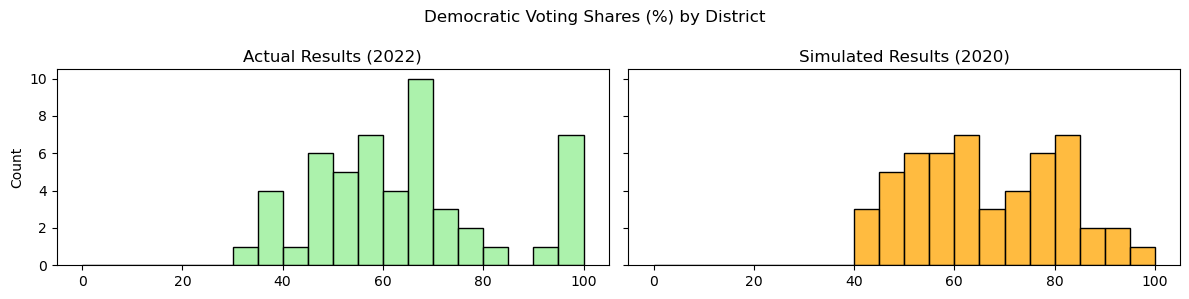

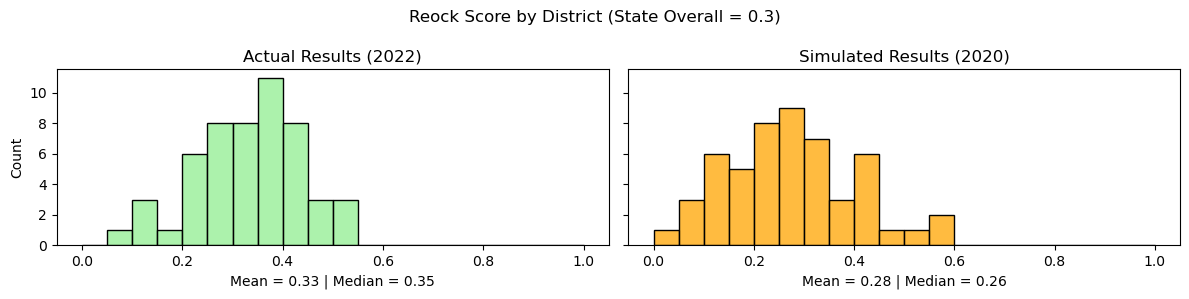

In [13]:
## California
get_voting_stats('CA')
get_reock_stats('CA')

CT
Party Vote (D, R): (57.8%, 42.2%) | (60.2%, 39.8%)
Seats Won (D, R): (5, 0) | (5, 0)
Proportional Seating (D, R): (3, 2) | (3, 2)
Competitiveness (NC, C, C*): (4, 0, 1) | (4, 0, 1)
Uncontested Seats (D, R): (0, 0)
{'State': 'CT', 'Actual.Reock.Mean': 0.43597, 'Algo.Reock.Mean': 0.49821, 'Actual.Reock.Median': 0.43396, 'Algo.Reock.Median': 0.4938, 'Overall.Reock': 0.40219}


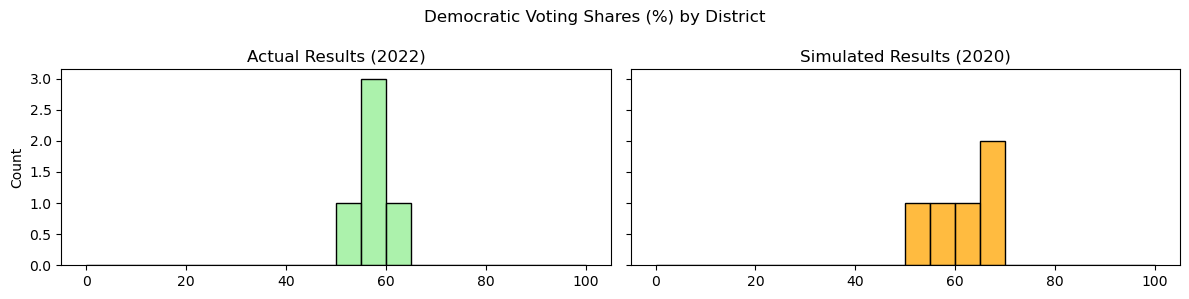

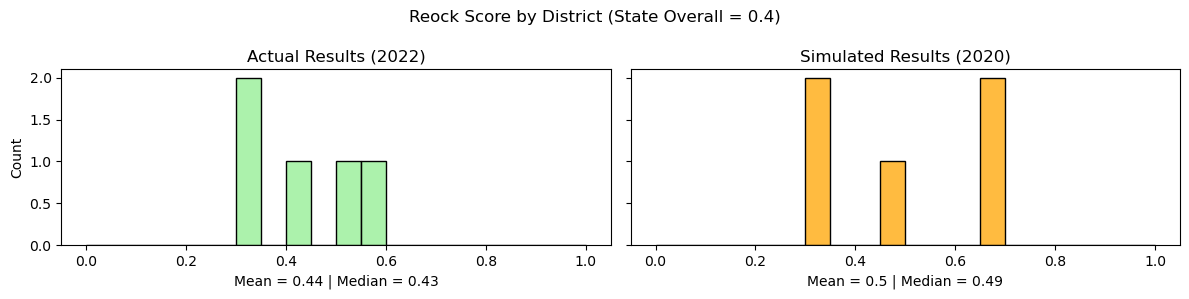

In [14]:
## California
get_voting_stats('CT')
get_reock_stats('CT')

FL
Party Vote (D, R): (40.5%, 59.5%) | (47.5%, 52.5%)
Seats Won (D, R): (8, 20) | (10, 18)
Proportional Seating (D, R): (11, 17) | (13, 15)
Competitiveness (NC, C, C*): (25, 2, 1) | (22, 1, 5)
Uncontested Seats (D, R): (0, 3)
{'State': 'FL', 'Actual.Reock.Mean': 0.4277, 'Algo.Reock.Mean': 0.39752, 'Actual.Reock.Median': 0.44188, 'Algo.Reock.Median': 0.41158, 'Overall.Reock': 0.22246}


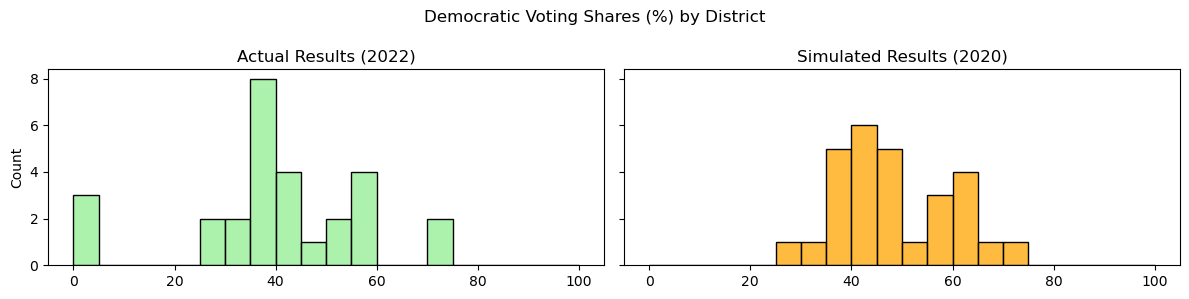

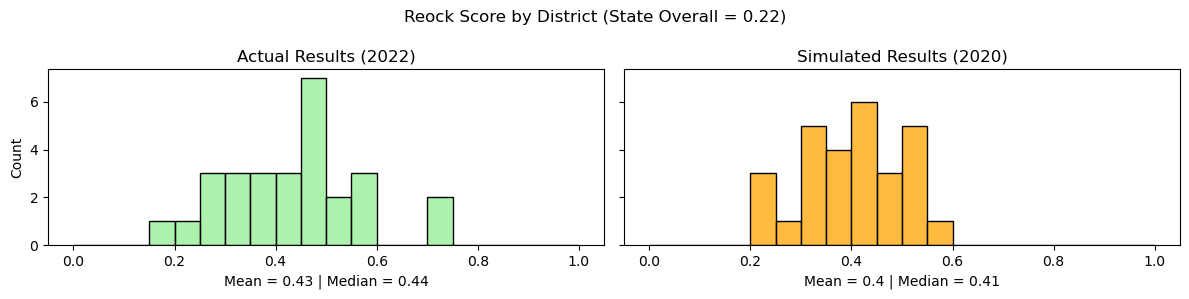

In [15]:
## Florida
state_ = 'FL'
get_voting_stats('FL')
get_reock_stats('FL')

GA
Party Vote (D, R): (47.7%, 52.3%) | (49.0%, 51.0%)
Seats Won (D, R): (5, 9) | (5, 9)
Proportional Seating (D, R): (7, 7) | (7, 7)
Competitiveness (NC, C, C*): (13, 1, 0) | (12, 1, 1)
Uncontested Seats (D, R): (0, 0)
{'State': 'GA', 'Actual.Reock.Mean': 0.45279, 'Algo.Reock.Mean': 0.47105, 'Actual.Reock.Median': 0.47201, 'Algo.Reock.Median': 0.47197, 'Overall.Reock': 0.52101}


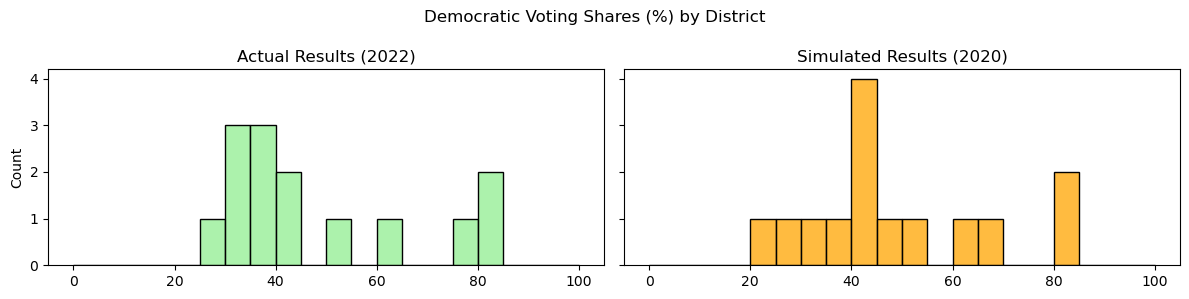

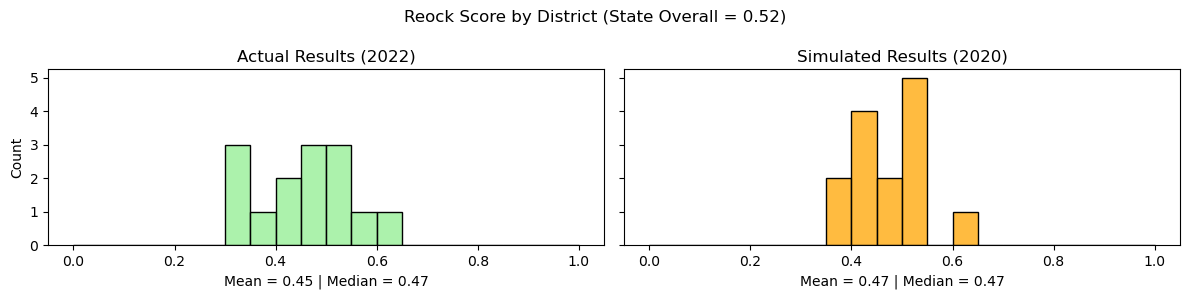

In [16]:
state_ = 'GA'
get_voting_stats(state_)
get_reock_stats(state_)

MA
Party Vote (D, R): (69.8%, 30.200000000000003%) | (78.0%, 22.0%)
Seats Won (D, R): (9, 0) | (9, 0)
Proportional Seating (D, R): (6, 3) | (7, 2)
Competitiveness (NC, C, C*): (9, 0, 0) | (9, 0, 0)
Uncontested Seats (D, R): (1, 0)
{'State': 'MA', 'Actual.Reock.Mean': 0.30312, 'Algo.Reock.Mean': 0.41928, 'Actual.Reock.Median': 0.26689, 'Algo.Reock.Median': 0.40586, 'Overall.Reock': 0.21999}


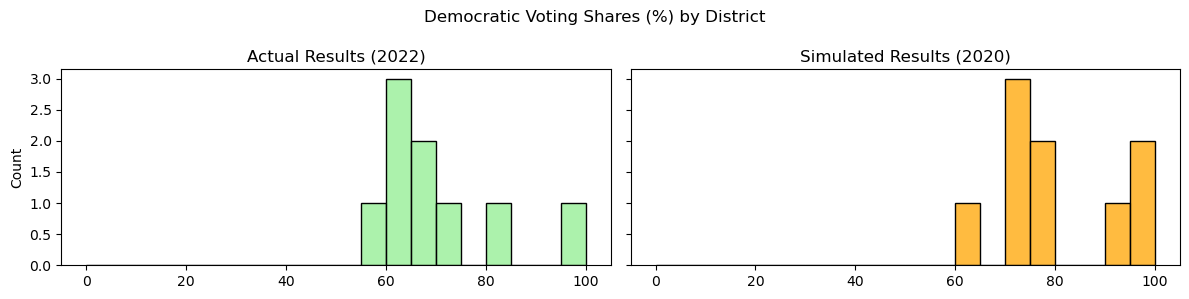

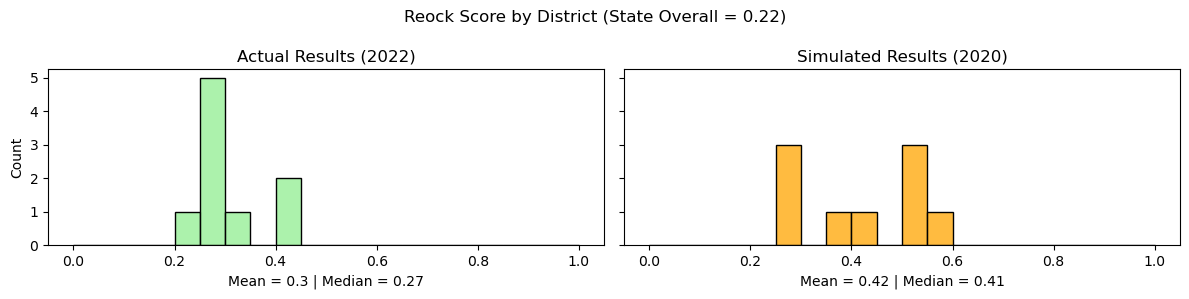

In [17]:
state_ = 'MA'
get_voting_stats(state_)
get_reock_stats(state_)

MD
Party Vote (D, R): (66.1%, 33.900000000000006%) | (65.0%, 35.0%)
Seats Won (D, R): (7, 1) | (5, 3)
Proportional Seating (D, R): (5, 3) | (5, 3)
Competitiveness (NC, C, C*): (7, 1, 0) | (5, 1, 2)
Uncontested Seats (D, R): (0, 1)
{'State': 'MD', 'Actual.Reock.Mean': 0.30895, 'Algo.Reock.Mean': 0.33509, 'Actual.Reock.Median': 0.26965, 'Algo.Reock.Median': 0.33403, 'Overall.Reock': 0.16076}


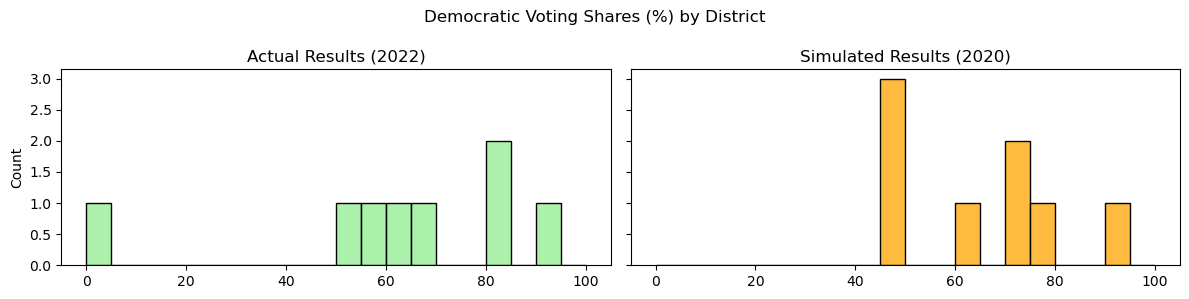

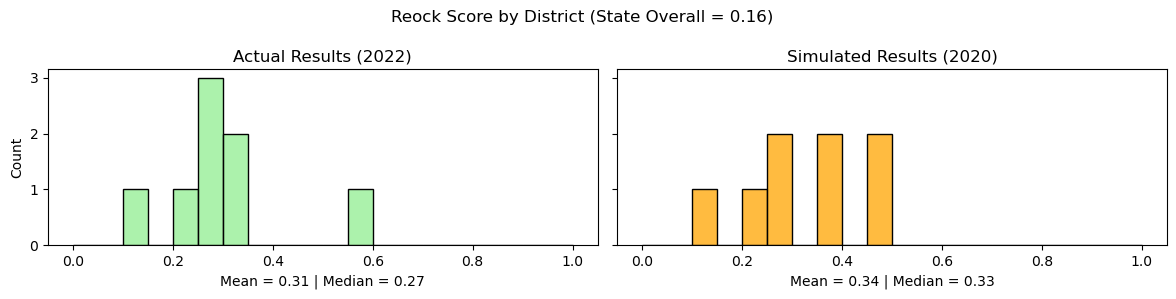

In [18]:
state_ = 'MD'
get_voting_stats(state_)
get_reock_stats(state_)

MI
Party Vote (D, R): (48.8%, 51.2%) | (50.7%, 49.3%)
Seats Won (D, R): (6, 7) | (6, 7)
Proportional Seating (D, R): (6, 7) | (7, 6)
Competitiveness (NC, C, C*): (11, 1, 1) | (11, 2, 0)
Uncontested Seats (D, R): (0, 0)
{'State': 'MI', 'Actual.Reock.Mean': 0.38557, 'Algo.Reock.Mean': 0.39411, 'Actual.Reock.Median': 0.39522, 'Algo.Reock.Median': 0.40517, 'Overall.Reock': 0.28056}


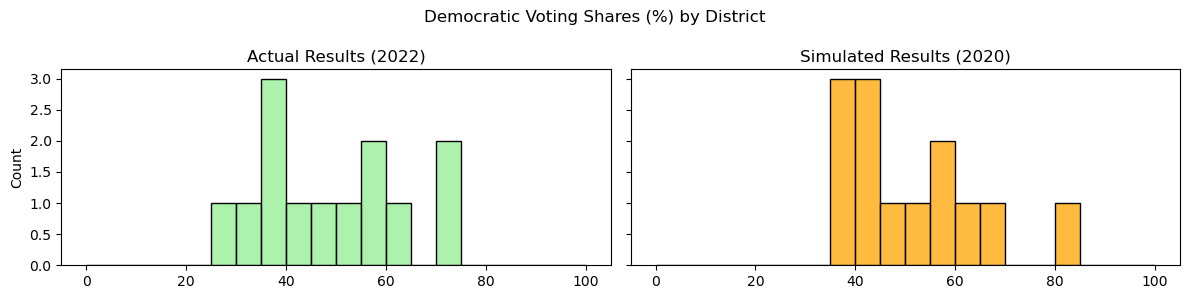

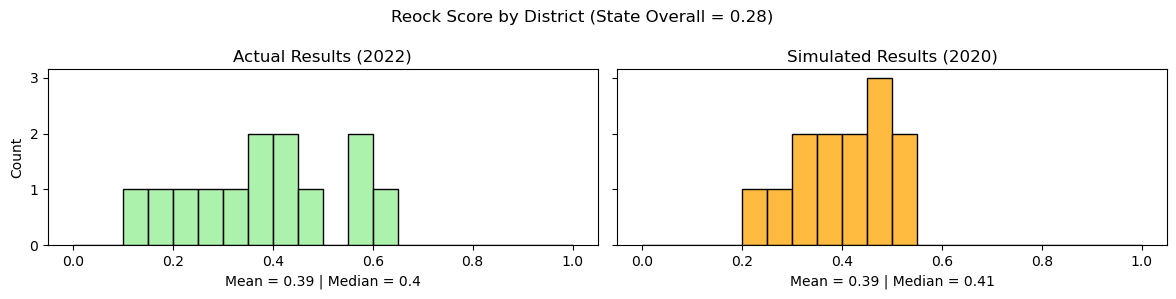

In [19]:
state_ = 'MI'
get_voting_stats(state_)
get_reock_stats(state_)

MN
Party Vote (D, R): (51.0%, 49.0%) | (51.3%, 48.7%)
Seats Won (D, R): (4, 4) | (4, 4)
Proportional Seating (D, R): (4, 4) | (4, 4)
Competitiveness (NC, C, C*): (7, 1, 0) | (6, 1, 1)
Uncontested Seats (D, R): (0, 0)
{'State': 'MN', 'Actual.Reock.Mean': 0.39904, 'Algo.Reock.Mean': 0.3776, 'Actual.Reock.Median': 0.39795, 'Algo.Reock.Median': 0.38712, 'Overall.Reock': 0.44242}


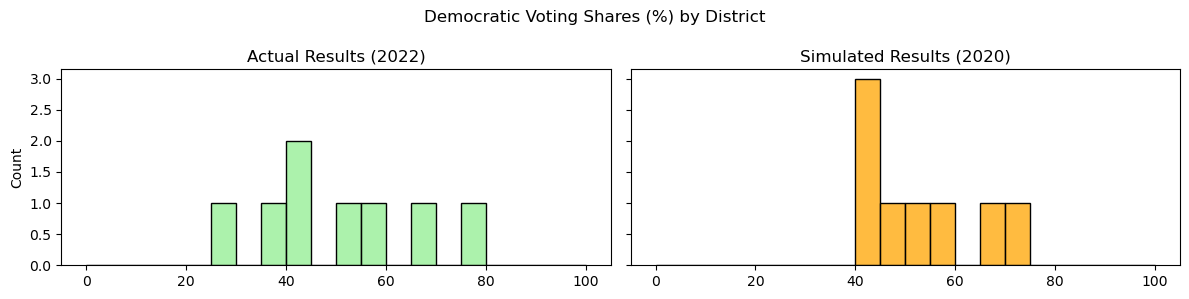

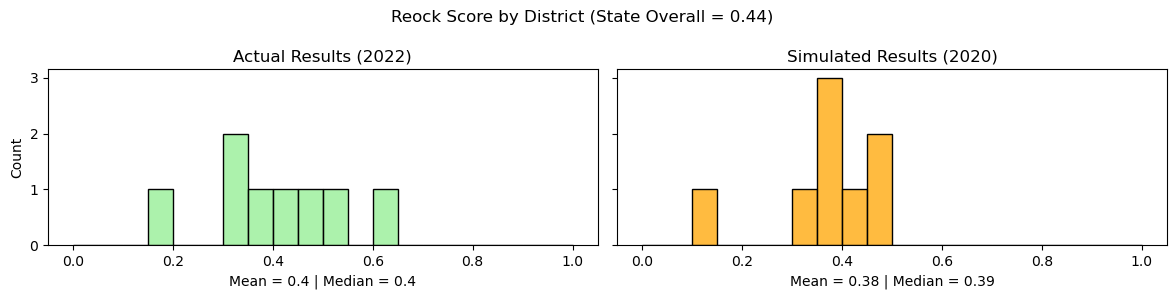

In [32]:
state_ = 'MN'
get_voting_stats(state_)
get_reock_stats(state_)

NC
Party Vote (D, R): (47.8%, 52.2%) | (50.3%, 49.7%)
Seats Won (D, R): (7, 7) | (5, 9)
Proportional Seating (D, R): (7, 7) | (7, 7)
Competitiveness (NC, C, C*): (10, 2, 2) | (9, 2, 3)
Uncontested Seats (D, R): (0, 0)
{'State': 'NC', 'Actual.Reock.Mean': 0.41814, 'Algo.Reock.Mean': 0.4525, 'Actual.Reock.Median': 0.41621, 'Algo.Reock.Median': 0.45107, 'Overall.Reock': 0.222}


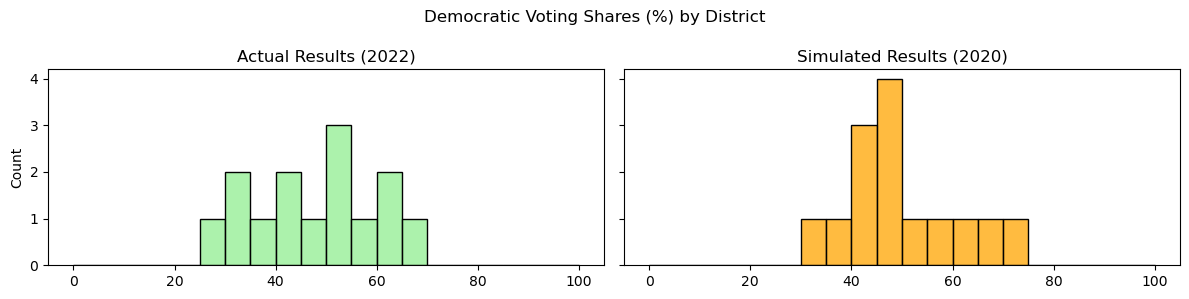

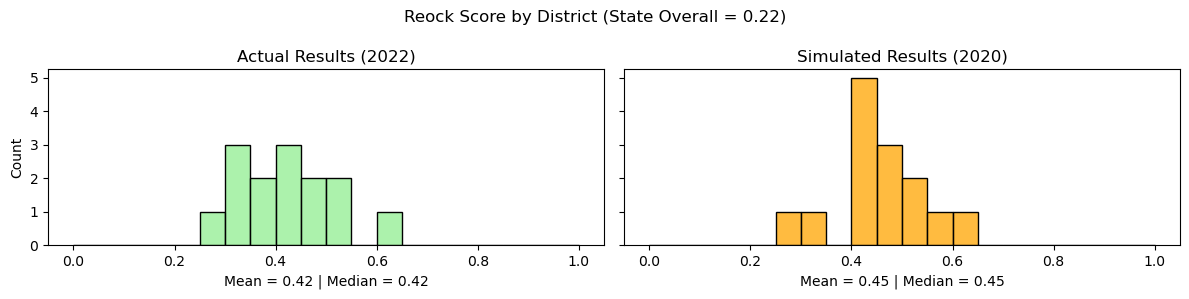

In [21]:
state_ = 'NC'
get_voting_stats(state_)
get_reock_stats(state_)

NH
Party Vote (D, R): (55.0%, 45.0%) | (53.9%, 46.1%)
Seats Won (D, R): (2, 0) | (2, 0)
Proportional Seating (D, R): (1, 1) | (1, 1)
Competitiveness (NC, C, C*): (1, 1, 0) | (0, 2, 0)
Uncontested Seats (D, R): (0, 0)
{'State': 'NH', 'Actual.Reock.Mean': 0.32002, 'Algo.Reock.Mean': 0.40608, 'Actual.Reock.Median': 0.32002, 'Algo.Reock.Median': 0.40608, 'Overall.Reock': 0.40259}


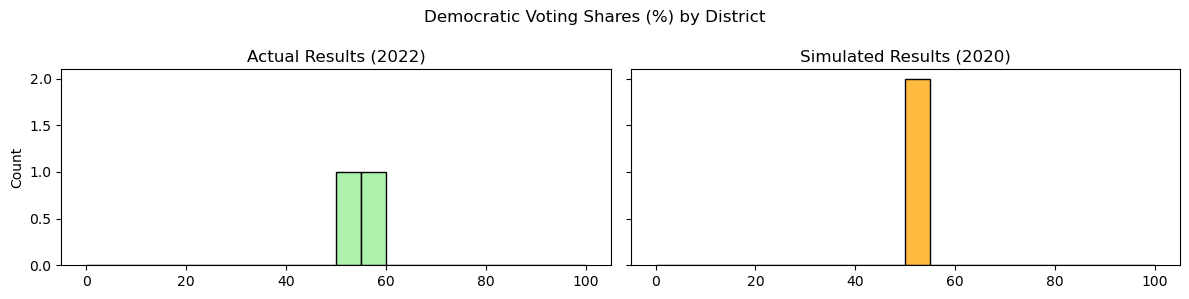

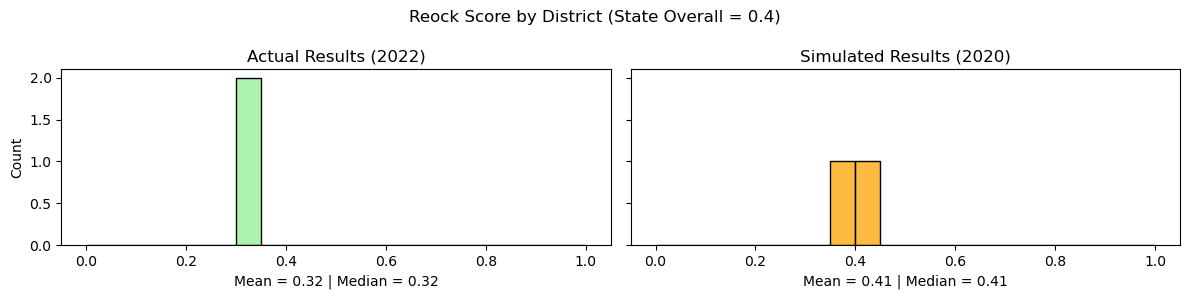

In [22]:
state_ = 'NH'
get_voting_stats(state_)
get_reock_stats(state_)

NJ
Party Vote (D, R): (55.0%, 45.0%) | (57.9%, 42.1%)
Seats Won (D, R): (9, 3) | (9, 3)
Proportional Seating (D, R): (7, 5) | (7, 5)
Competitiveness (NC, C, C*): (11, 0, 1) | (9, 1, 2)
Uncontested Seats (D, R): (0, 0)
{'State': 'NJ', 'Actual.Reock.Mean': 0.34545, 'Algo.Reock.Mean': 0.44996, 'Actual.Reock.Median': 0.32549, 'Algo.Reock.Median': 0.44617, 'Overall.Reock': 0.45339}


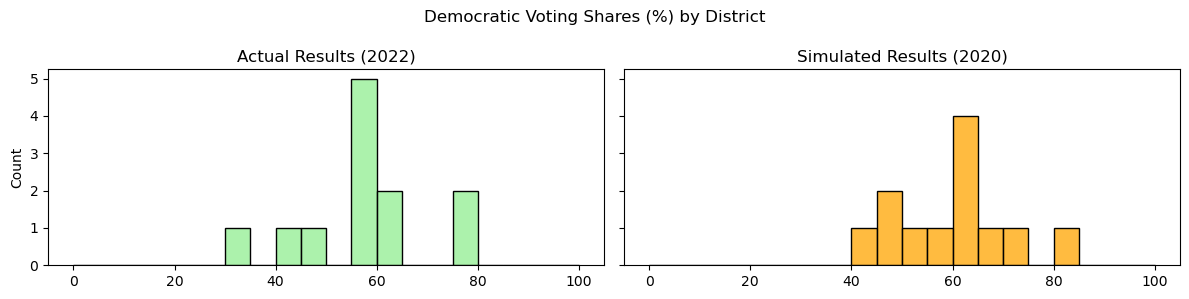

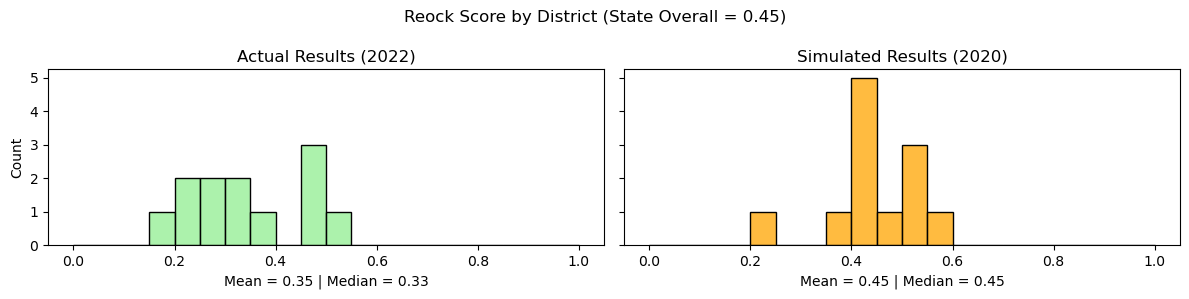

In [23]:
state_ = 'NJ'
get_voting_stats(state_)
get_reock_stats(state_)

NV
Party Vote (D, R): (48.3%, 51.7%) | (51.2%, 48.8%)
Seats Won (D, R): (3, 1) | (3, 1)
Proportional Seating (D, R): (2, 2) | (2, 2)
Competitiveness (NC, C, C*): (1, 1, 2) | (3, 0, 1)
Uncontested Seats (D, R): (0, 0)
{'State': 'NV', 'Actual.Reock.Mean': 0.42988, 'Algo.Reock.Mean': 0.46908, 'Actual.Reock.Median': 0.45303, 'Algo.Reock.Median': 0.50499, 'Overall.Reock': 0.49032}


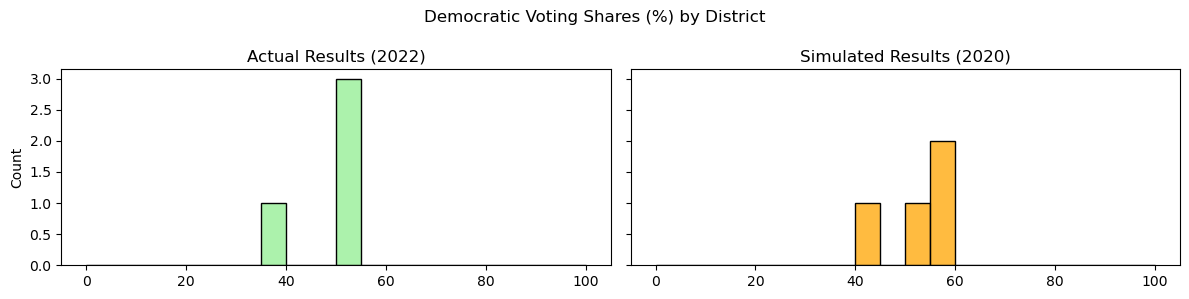

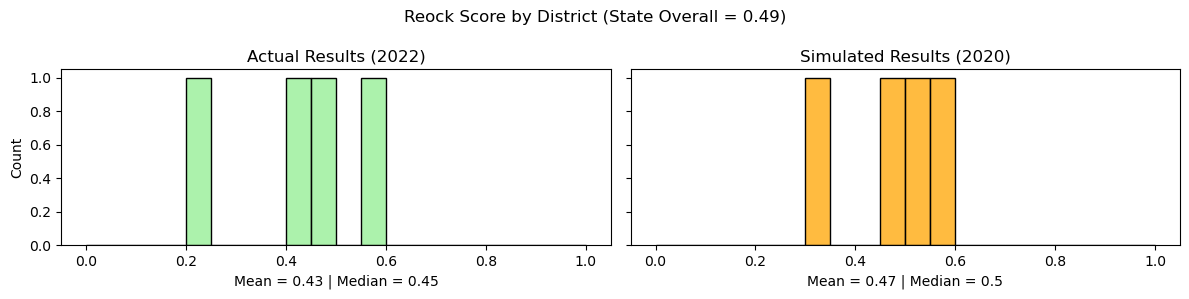

In [24]:
state_ = 'NV'
get_voting_stats(state_)
get_reock_stats(state_)

OH
Party Vote (D, R): (43.4%, 56.6%) | (43.0%, 57.0%)
Seats Won (D, R): (5, 10) | (5, 10)
Proportional Seating (D, R): (7, 8) | (6, 9)
Competitiveness (NC, C, C*): (13, 1, 1) | (12, 2, 1)
Uncontested Seats (D, R): (0, 0)
{'State': 'OH', 'Actual.Reock.Mean': 0.39383, 'Algo.Reock.Mean': 0.40309, 'Actual.Reock.Median': 0.36855, 'Algo.Reock.Median': 0.40121, 'Overall.Reock': 0.54676}


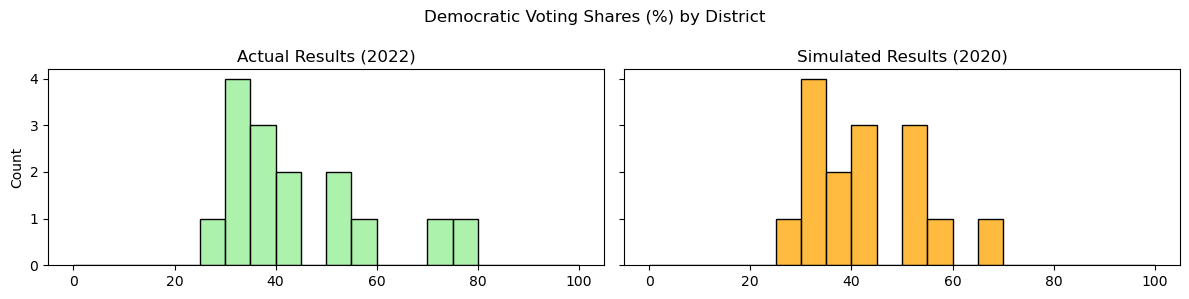

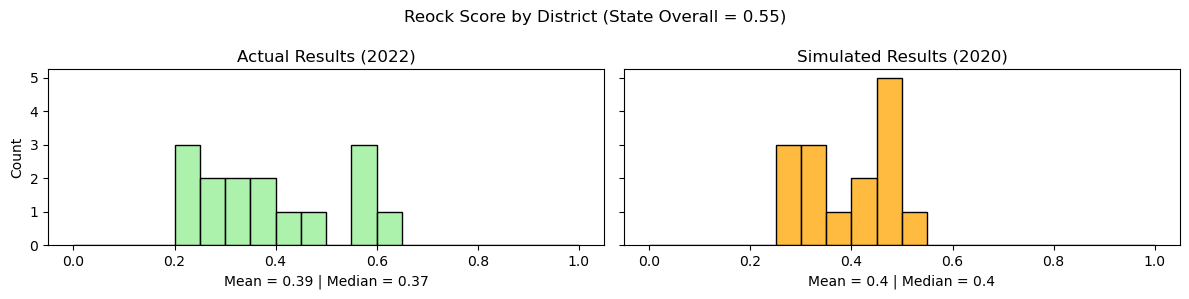

In [25]:
state_ = 'OH'
get_voting_stats(state_)
get_reock_stats(state_)

OR
Party Vote (D, R): (54.3%, 45.7%) | (57.1%, 42.9%)
Seats Won (D, R): (4, 2) | (4, 2)
Proportional Seating (D, R): (3, 3) | (3, 3)
Competitiveness (NC, C, C*): (3, 1, 2) | (5, 1, 0)
Uncontested Seats (D, R): (0, 0)
{'State': 'OR', 'Actual.Reock.Mean': 0.40786, 'Algo.Reock.Mean': 0.49155, 'Actual.Reock.Median': 0.41611, 'Algo.Reock.Median': 0.52906, 'Overall.Reock': 0.48416}


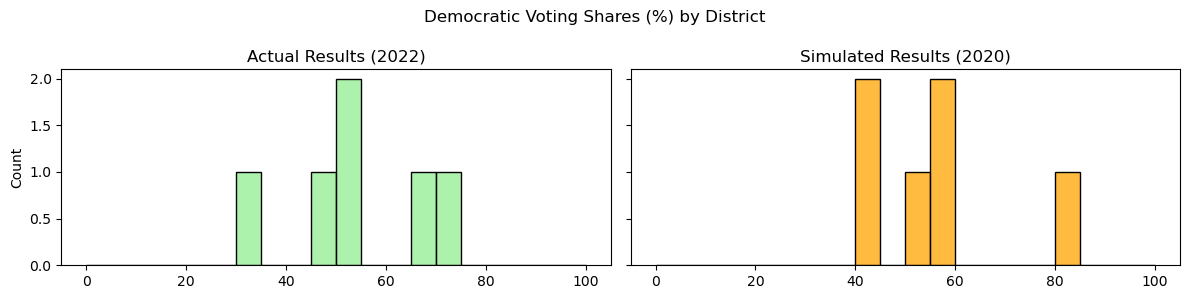

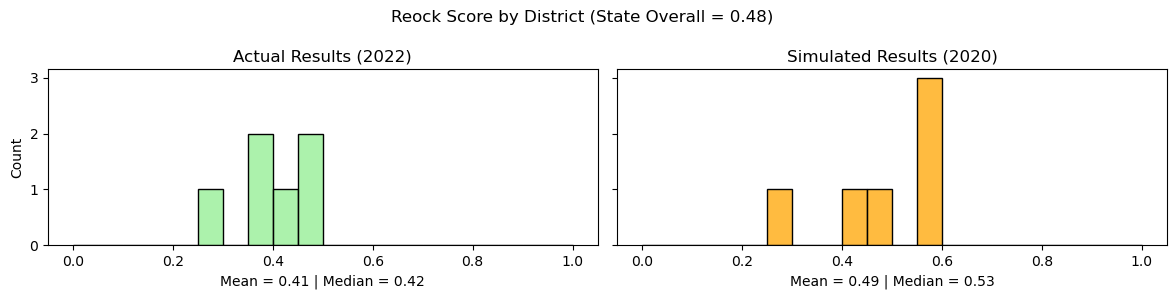

In [26]:
state_ = 'OR'
get_voting_stats(state_)
get_reock_stats(state_)

PA
Party Vote (D, R): (47.4%, 52.6%) | (49.4%, 50.6%)
Seats Won (D, R): (9, 8) | (5, 12)
Proportional Seating (D, R): (8, 9) | (8, 9)
Competitiveness (NC, C, C*): (12, 3, 2) | (12, 1, 4)
Uncontested Seats (D, R): (1, 2)
{'State': 'PA', 'Actual.Reock.Mean': 0.41579, 'Algo.Reock.Mean': 0.44121, 'Actual.Reock.Median': 0.43241, 'Algo.Reock.Median': 0.45236, 'Overall.Reock': 0.4236}


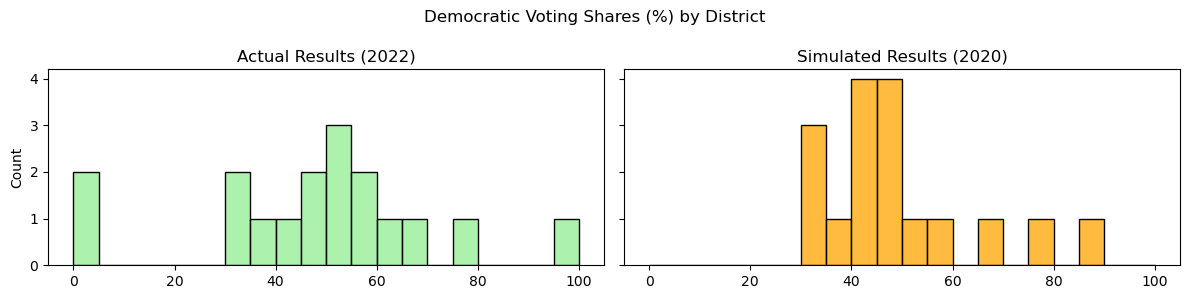

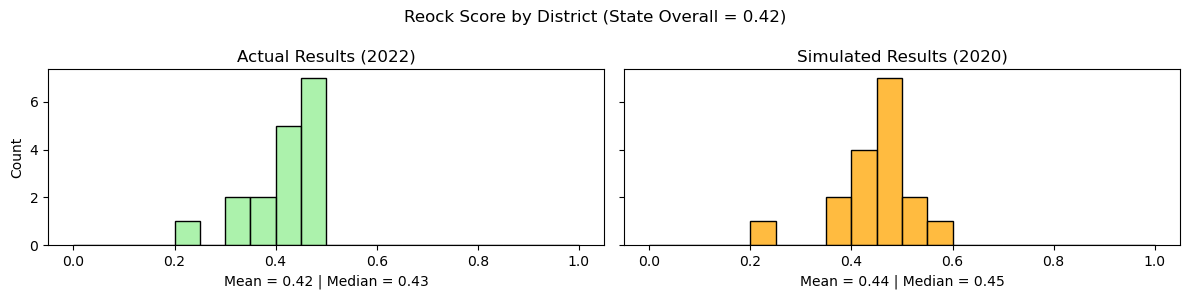

In [27]:
state_ = 'PA'
get_voting_stats(state_)
get_reock_stats(state_)

SC
Party Vote (D, R): (32.9%, 67.1%) | (43.3%, 56.7%)
Seats Won (D, R): (1, 6) | (1, 6)
Proportional Seating (D, R): (2, 5) | (3, 4)
Competitiveness (NC, C, C*): (7, 0, 0) | (4, 1, 2)
Uncontested Seats (D, R): (0, 2)
{'State': 'SC', 'Actual.Reock.Mean': 0.35749, 'Algo.Reock.Mean': 0.48534, 'Actual.Reock.Median': 0.36088, 'Algo.Reock.Median': 0.46419, 'Overall.Reock': 0.42053}


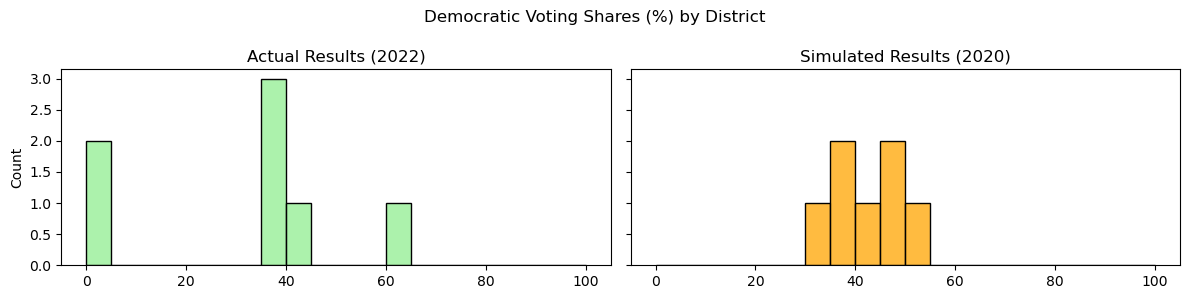

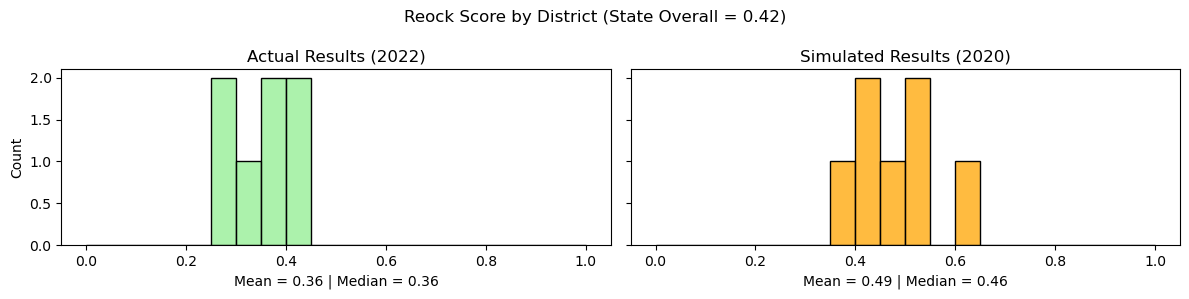

In [28]:
state_ = 'SC'
get_voting_stats(state_)
get_reock_stats(state_)

TX
Party Vote (D, R): (40.0%, 60.0%) | (45.2%, 54.8%)
Seats Won (D, R): (13, 25) | (16, 22)
Proportional Seating (D, R): (15, 23) | (17, 21)
Competitiveness (NC, C, C*): (36, 2, 0) | (31, 3, 4)
Uncontested Seats (D, R): (0, 5)
{'State': 'TX', 'Actual.Reock.Mean': 0.32336, 'Algo.Reock.Mean': 0.37205, 'Actual.Reock.Median': 0.34465, 'Algo.Reock.Median': 0.3438, 'Overall.Reock': 0.48829}


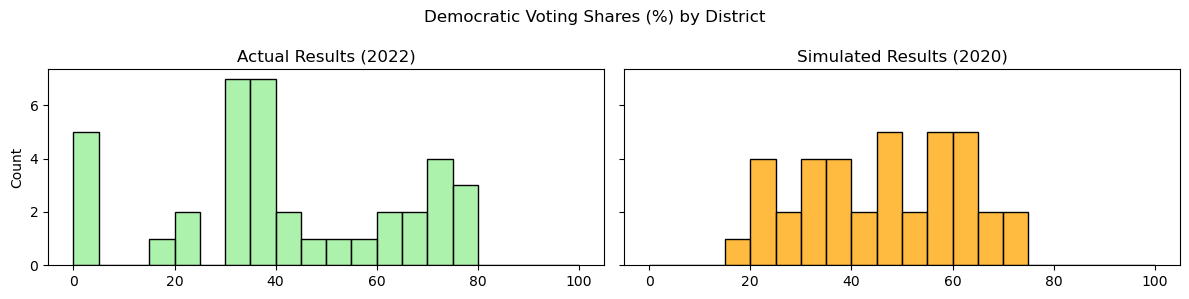

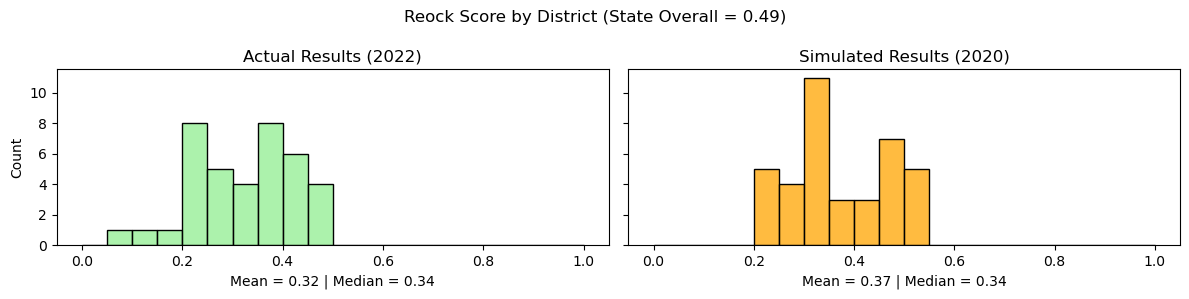

In [29]:
state_ = 'TX'
get_voting_stats(state_)
get_reock_stats(state_)

VA
Party Vote (D, R): (51.8%, 48.2%) | (52.4%, 47.6%)
Seats Won (D, R): (6, 5) | (8, 3)
Proportional Seating (D, R): (6, 5) | (6, 5)
Competitiveness (NC, C, C*): (8, 1, 2) | (8, 1, 2)
Uncontested Seats (D, R): (0, 0)
{'State': 'VA', 'Actual.Reock.Mean': 0.37906, 'Algo.Reock.Mean': 0.37715, 'Actual.Reock.Median': 0.41103, 'Algo.Reock.Median': 0.38754, 'Overall.Reock': 0.19437}


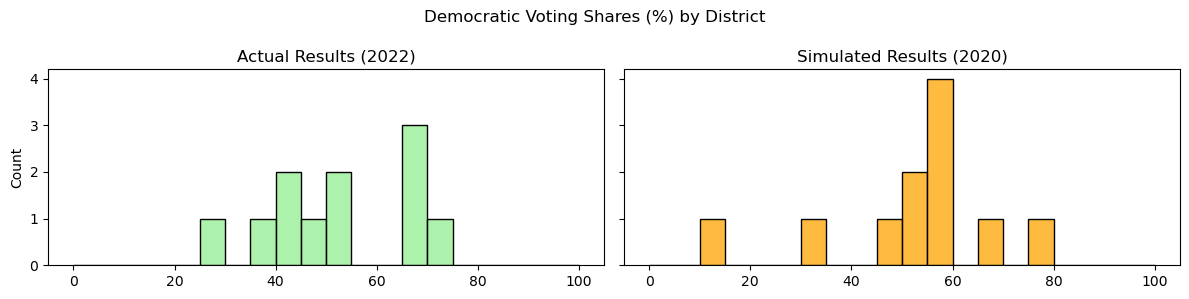

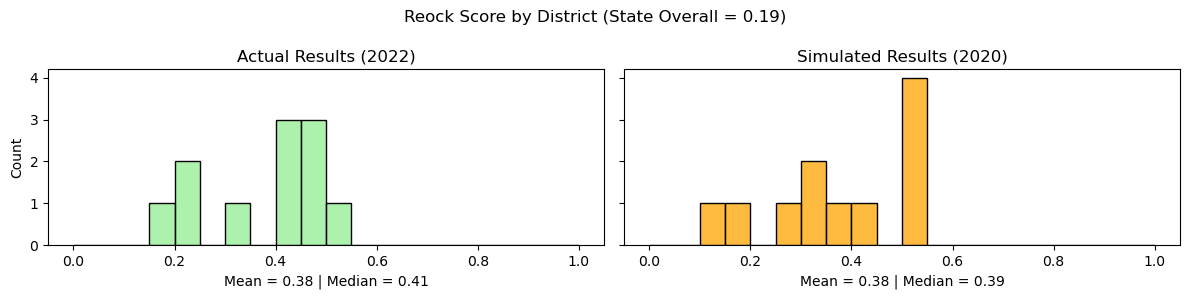

In [30]:
state_ = 'VA'
get_voting_stats(state_)
get_reock_stats(state_)

WI
Party Vote (D, R): (41.9%, 58.1%) | (48.5%, 51.5%)
Seats Won (D, R): (2, 6) | (2, 6)
Proportional Seating (D, R): (3, 5) | (4, 4)
Competitiveness (NC, C, C*): (6, 1, 1) | (7, 1, 0)
Uncontested Seats (D, R): (0, 2)
{'State': 'WI', 'Actual.Reock.Mean': 0.41732, 'Algo.Reock.Mean': 0.47044, 'Actual.Reock.Median': 0.3705, 'Algo.Reock.Median': 0.44655, 'Overall.Reock': 0.53529}


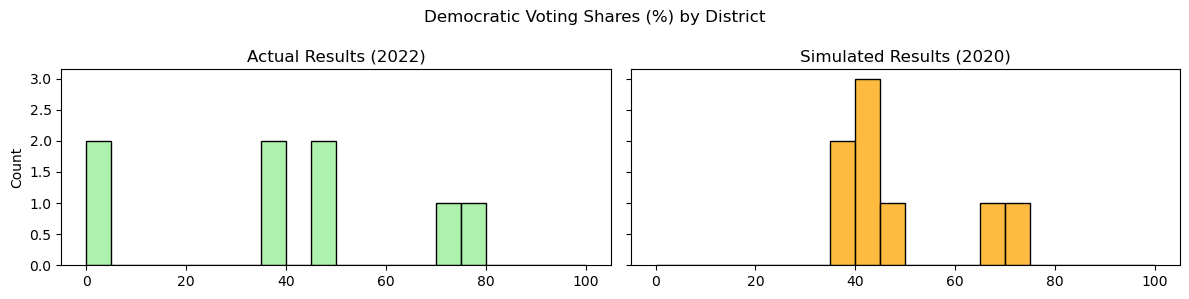

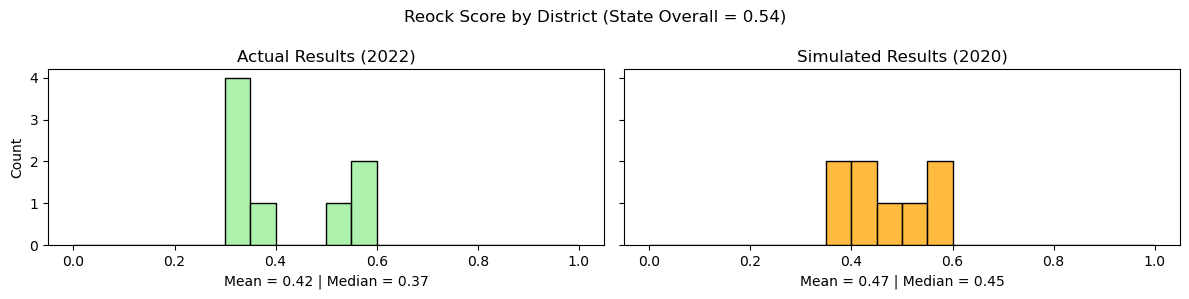

In [31]:
state_ = 'WI'
get_voting_stats(state_)
get_reock_stats(state_)